In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import sys
import os

from ExptTrace import ExptTrace
from FileManager import FileManager
from misc import rcsetup

rcsetup()

sys.path.append("../")

from kernels import GaussianKernel, LaplaceKernel
from utils import ensure_torch, ensure_numpy, Hyperparams
from eigenlearning import eigenlearning

kerneltype_dict = {
    "GaussianKernel": GaussianKernel,
    "LaplaceKernel": LaplaceKernel,
}

In [2]:
import matplotlib.colors as mcolors

colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]

def lighten(color, amount=0.5):
    rgb = mcolors.to_rgb(mcolors.XKCD_COLORS.get(color, color))
    if amount >= 0:
        new_rgb = tuple(c + (1 - c) * amount for c in rgb)
    else:
        new_rgb = tuple(c * (1 + amount) for c in rgb)
    # Clip values to [0, 1]
    new_rgb = tuple(min(max(x, 0), 1) for x in new_rgb)
    return new_rgb

## check whether tailsum ridge fixes kappa estim

In [76]:
from data import get_powerlaw
from feature_decomp import generate_fra_monomials

kernel_widths = [1, 4]
data_dim = 200
data_eigval_exps = [0.6, 1.2, 2.0]
n_samples = 20_000
p_modes = 20_000
ridges = np.array([1e-4, 1e-2, 1e0])
nn = np.logspace(1, 5, num=50).astype(int)

et_emp_eigvals, et_hehe_eigvals = ExptTrace.multi_init(2, ["d_eff", "kernel_width"])
et_kappa_ratio = ExptTrace(["d_eff", "kernel_width", "ridge", "n"])

for kernel_width in kernel_widths:
    for data_eigval_exp in data_eigval_exps:
        data_eigvals = get_powerlaw(data_dim, data_eigval_exp, offset=6)
        # on average, we expect norm(x_i) ~ Tr(data_eigvals)
        X = ensure_torch(torch.normal(0, 1, (n_samples, data_dim))) * torch.sqrt(ensure_torch(data_eigvals))

        d_eff = 1/(data_eigvals**2).sum().item()

        eval_level_coeff = LaplaceKernel.get_level_coeff_fn(data_eigvals, kernel_width=kernel_width)
        hehe_eigvals, monomials = generate_fra_monomials(data_eigvals, p_modes, eval_level_coeff)
        et_hehe_eigvals[d_eff, kernel_width] = hehe_eigvals

        print(f"d_eff={d_eff:.2f}. Computing kernel eigvals... ", end="")
        kernel = LaplaceKernel(X, kernel_width=kernel_width)
        emp_eigvals = ensure_numpy(kernel.eigenvals())
        et_emp_eigvals[d_eff, kernel_width] = emp_eigvals
        print("done.")
        
        for ridge in ridges:
            hehe_ridge = ridge + 1.0 - hehe_eigvals.sum()
            for n_train in nn:
                el_hehe = eigenlearning(n_train, hehe_eigvals, 1+0*hehe_eigvals, ridge=hehe_ridge)
                el_emp = eigenlearning(n_train, emp_eigvals, 1+0*hehe_eigvals, ridge=ridge)
                kappa_ratio = el_emp['kappa'] / el_hehe['kappa']
                et_kappa_ratio[d_eff, kernel_width, ridge, n_train] = kappa_ratio
        torch.cuda.empty_cache()
    print()


d_eff=141.50. Computing kernel eigvals... done.
d_eff=51.60. Computing kernel eigvals... done.
d_eff=15.80. Computing kernel eigvals... done.

d_eff=141.50. Computing kernel eigvals... done.
d_eff=51.60. Computing kernel eigvals... done.
d_eff=15.80. Computing kernel eigvals... done.



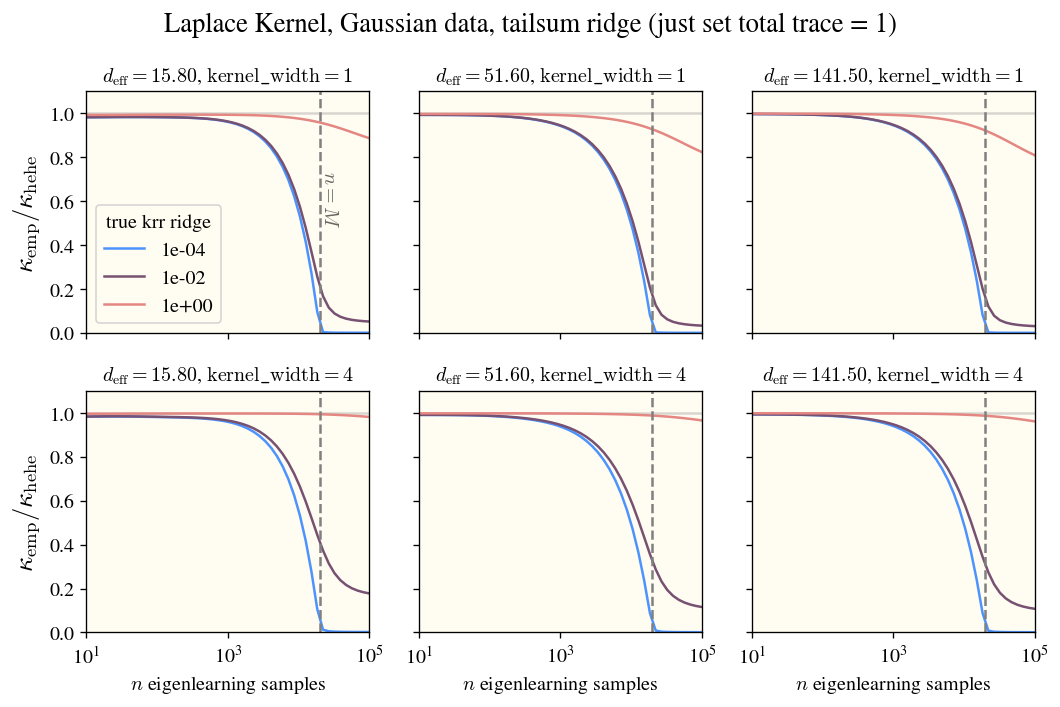

In [120]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6), sharey=True, sharex=True)
d_effs = et_emp_eigvals.get_axis("d_eff")

for i, kernel_width in enumerate(kernel_widths):
    for j, d_eff in enumerate(d_effs):
        ax = axes[i, j]
        for k, ridge in enumerate(ridges):
            kappa_ratio = et_kappa_ratio[d_eff, kernel_width, ridge, :].squeeze()
            ax.plot(nn, kappa_ratio, label=f"{ridge:.0e}", color=lighten(colors[k % len(colors)], 0.3))
        ax.set_xscale("log")
        ax.set_ylim(0, 1.1)
        ax.set_xlim(1e1, 1e5)
        ax.axvline(x=n_samples, color='gray', linestyle='--')
        ax.axhline(y=1, color='gray', alpha=0.3, linestyle='-', zorder=-4)
        ax.set_title(f"$d_\\mathrm{{eff}} = {d_eff:.2f}$, $\\mathrm{{kernel\\_width}} = {kernel_width}$")
        if i == 1:
            ax.set_xlabel(f"$n$ eigenlearning samples")
        if j == 0:
            ax.set_ylabel(f"$\\kappa_\\mathrm{{emp}}/\\kappa_\\mathrm{{hehe}}$", fontsize=16)
        if i == 0 and j == 0:
            ax.legend(title="true krr ridge")
            ax.text(27_000, 0.5, f"$n=M$", ha="center", alpha=0.6, rotation=-90)

plt.suptitle("Laplace Kernel, Gaussian data, tailsum ridge (just set total trace = 1)", fontsize=16)
plt.tight_layout()
plt.show()

## three kappa estims

In [72]:
from data import get_powerlaw
from feature_decomp import generate_fra_monomials
from ImageData import ImageData, preprocess
from einops import rearrange


kernel_width = 4
data_dim = 200
data_eigval_exp = 1.2
n_samples = 20_000
p_modes = 20_000
ridges = np.array([1e-4, 1e-3, 1e-2])
nn = np.unique(np.logspace(0.5, 4, num=30).astype(int))
zca_strength = 1e-2
dataset = "imagenet32"


if dataset == "gaussian":
    data_eigvals = get_powerlaw(data_dim, data_eigval_exp, offset=6)
    # on average, we expect norm(x_i) ~ Tr(data_eigvals)
    X = ensure_torch(torch.normal(0, 1, (n_samples, data_dim))) * torch.sqrt(ensure_torch(data_eigvals))
else:
    datapath = os.getenv("DATASETPATH")
    if dataset == "cifar10":
        data_dir = os.path.join(datapath, "cifar10")
        cifar10 = ImageData('cifar10', data_dir, classes=None)
        X_raw, _ = cifar10.get_dataset(n_samples, get="train")
    if dataset == "imagenet32":
        fn = os.path.join(datapath, "imagenet", f"{dataset}.npz")
        data = np.load(fn)
        X_raw = data['data'][:n_samples].astype(float)
        X_raw = rearrange(X_raw, 'n (c h w) -> n c h w', c=3, h=32, w=32)
    X = preprocess(X_raw, center=True, grayscale=True, zca_strength=zca_strength)
    X = ensure_torch(X)
    # ensure typical sample has unit norm
    S = torch.linalg.svdvals(X)
    X *= torch.sqrt(n_samples / (S**2).sum())
    data_eigvals = S**2 / (S**2).sum()

d_eff = 1/(data_eigvals**2).sum().item()
print(f"d_eff = {d_eff:.2f}")

eval_level_coeff = LaplaceKernel.get_level_coeff_fn(data_eigvals, kernel_width=kernel_width)
hehe_eigvals, monomials = generate_fra_monomials(data_eigvals, p_modes, eval_level_coeff)

print(f"Computing kernel eigvals... ", end="")
kernel = LaplaceKernel(X, kernel_width=kernel_width)
emp_eigvals = ensure_numpy(kernel.eigenvals())
print("done.")


d_eff = 27.42
Computing kernel eigvals... done.


In [73]:
from kernels import estimate_kappa

def get_ntrials(ntrain):
    if ntrain < 100: return 20
    elif ntrain < 1000: return 5
    elif ntrain < 10000: return 2
    return 1


et_kappa_hehe = ExptTrace(["ridge", "n"])
et_kappa_emp = ExptTrace(["ridge", "n"])
et_kappa_itrik = ExptTrace(["trial", "ridge", "n"])

for ridge in ridges:
    hehe_ridge = ridge + 1.0 - hehe_eigvals.sum()
    for n_train in nn:
        print(f"{n_train}", end=" ")
        el_hehe = eigenlearning(n_train, hehe_eigvals, 1+0*hehe_eigvals, ridge=hehe_ridge)
        el_emp = eigenlearning(n_train, emp_eigvals, 1+0*hehe_eigvals, ridge=ridge)
        et_kappa_hehe[ridge, n_train] = el_hehe['kappa']
        et_kappa_emp[ridge, n_train] = el_emp['kappa']
        for trial in range(get_ntrials(n_train)):
            et_kappa_itrik[trial, ridge, n_train] = estimate_kappa(kernel, n_train, ridge)
        torch.cuda.empty_cache()
    print()

3 4 5 7 9 12 16 22 29 38 50 67 88 117 154 204 269 356 470 621 819 1082 1429 1887 2492 3290 4344 5736 7573 10000 
3 4 5 7 9 12 16 22 29 38 50 67 88 117 154 204 269 356 470 621 819 1082 1429 1887 2492 3290 4344 5736 7573 10000 
3 4 5 7 9 12 16 22 29 38 50 67 88 117 154 204 269 356 470 621 819 1082 1429 1887 2492 3290 4344 5736 7573 10000 


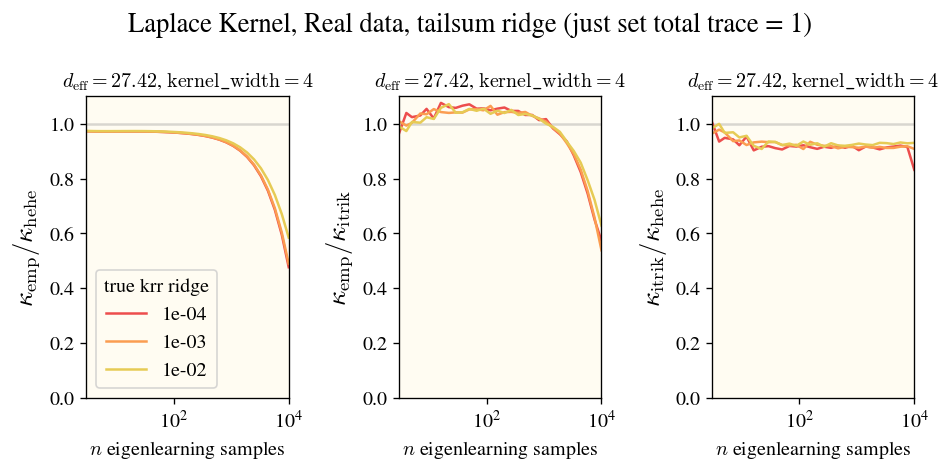

In [74]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))

for i in range(3):
    ax = axes.flat[i]
    for j, ridge in enumerate(ridges):
        if i == 0:
            kappa_ratio = et_kappa_emp[ridge, :].squeeze() / et_kappa_hehe[ridge, :].squeeze()
            ax.set_ylabel(f"$\\kappa_\\mathrm{{emp}}/\\kappa_\\mathrm{{hehe}}$", fontsize=16)
        if i == 1:
            kappa_ratio = et_kappa_emp[ridge, :].squeeze() / et_kappa_itrik[:, ridge, :].mean(axis=0).squeeze()
            ax.set_ylabel(f"$\\kappa_\\mathrm{{emp}}/\\kappa_\\mathrm{{itrik}}$", fontsize=16)
        if i == 2:
            kappa_ratio = et_kappa_itrik[:, ridge, :].mean(axis=0).squeeze() / et_kappa_hehe[ridge, :].squeeze()
            ax.set_ylabel(f"$\\kappa_\\mathrm{{itrik}}/\\kappa_\\mathrm{{hehe}}$", fontsize=16)
        ax.plot(nn, kappa_ratio, label=f"{ridge:.0e}", color=lighten(colors[j % len(colors)], 0.3))
    ax.set_xscale("log")
    ax.set_ylim(0, 1.1)
    ax.set_xlim(3e0, 1e4)
    # ax.axvline(x=n_samples, color='gray', linestyle='--')
    ax.axhline(y=1, color='gray', alpha=0.3, linestyle='-', zorder=-4)
    ax.set_title(f"$d_\\mathrm{{eff}} = {d_eff:.2f}$, $\\mathrm{{kernel\\_width}} = {kernel_width}$")
    ax.set_xlabel(f"$n$ eigenlearning samples")
    if i == 0:
        ax.legend(title="true krr ridge")

plt.suptitle("Laplace Kernel, Real data, tailsum ridge (just set total trace = 1)", fontsize=16)
plt.tight_layout()
plt.show()

## Learning curves

In [112]:
hypers = Hyperparams(
    expt_name = "hehe-eigenlearning",
    dataset = "gaussian",
    kernel_name = "LaplaceKernel",
    kernel_width = 4,
    n_samples = 20_000,
    p_modes = 20_000,
    # If using synth data, set these
    data_dim = 100,
    data_eigval_exp = 1.4,
    # If using natural image data, set these
    zca_strength = 0,
)

In [109]:
# SETUP FILE MANAGEMENT
#######################

exptpath = os.getenv("EXPTPATH")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
expt_dir = os.path.join(exptpath, "phlab", hypers.expt_name, hypers.dataset)
expt_dir = os.path.join(expt_dir, hypers.generate_filepath())

if not os.path.exists(expt_dir):
    assert False
expt_fm = FileManager(expt_dir)

In [113]:
def calc_coeffs(ystar, H, emp_eigvecs, ridge=0):
    emp_coeffs = emp_eigvecs.T @ ystar
    emp_coeffs /= np.linalg.norm(emp_coeffs)
    hehe_coeffs = torch.linalg.lstsq(ensure_torch(H), ensure_torch(ystar))[0]
    
    H_, y_ = map(ensure_torch, (H, ystar))
    A = H_.T @ H_ + ridge * ensure_torch(torch.eye(H_.shape[1]))
    b = H_.T @ y_
    hehe_coeffs = torch.cholesky_solve(b.unsqueeze(1), torch.linalg.cholesky(A)).squeeze(1)
    hehe_coeffs = ensure_numpy(hehe_coeffs) / np.sqrt(H.shape[0])
    hehe_coeffs /= np.linalg.norm(hehe_coeffs)
    return emp_coeffs, hehe_coeffs

result = expt_fm.load("result.pickle")
monomials = result["monomials"]
d_eff = result["d_eff"]
et_yhat = ExptTrace.deserialize(result["y_hat"])

emp_eigvals = result["emp_eigvals"]
hehe_eigvals = result["th_eigvals"]
iso_eigvals = result["iso_eigvals"]

targets = expt_fm.load("targets.pickle")
emp_eigvecs = expt_fm.load("emp_eigvecs.npy")
H = expt_fm.load("H.npy")
target = 1.25
ystar = targets[target]
emp_coeffs, hehe_coeffs = calc_coeffs(ystar, H, emp_eigvecs, ridge=1e-2)

ntest = result["n_test"]
ridges = et_yhat.get_axis("ridge")
ntrains = et_yhat.get_axis("ntrain")
trials = et_yhat.get_axis("trial")

In [114]:
emp_coeffs, hehe_coeffs = calc_coeffs(ystar, H, emp_eigvecs, ridge=6e-2)
yhat = et_yhat[:, :, ridges[0], target].squeeze()
mse = ((yhat - ystar[-ntest:])**2).mean(axis=-1)
lrn_curve_emp, lrn_curve_emp_std = mse.mean(axis=0), mse.std(axis=0)

hehe_ridge = ridges[0] + 1.0 - hehe_eigvals.sum()
print(ridges[0], hehe_ridge)

ntrains_dense = np.logspace(np.log10(ntrains[0]), np.log10(ntrains[-1]), 200)
el_emp = lambda n: eigenlearning(n, emp_eigvals, emp_coeffs, ridge=ridges[0])
el_hehe = lambda n: eigenlearning(n, hehe_eigvals, emp_coeffs, ridge=hehe_ridge)
el_iso = lambda n: eigenlearning(n, iso_eigvals, emp_coeffs, ridge=ridges[0])
mse_el_emp = np.array([el_emp(n)["test_mse"] for n in ntrains_dense])
mse_el_hehe = np.array([el_hehe(n)["test_mse"] for n in ntrains_dense])
mse_el_iso = np.array([el_iso(n)["test_mse"] for n in ntrains_dense])

0.0001 0.07699107449878484


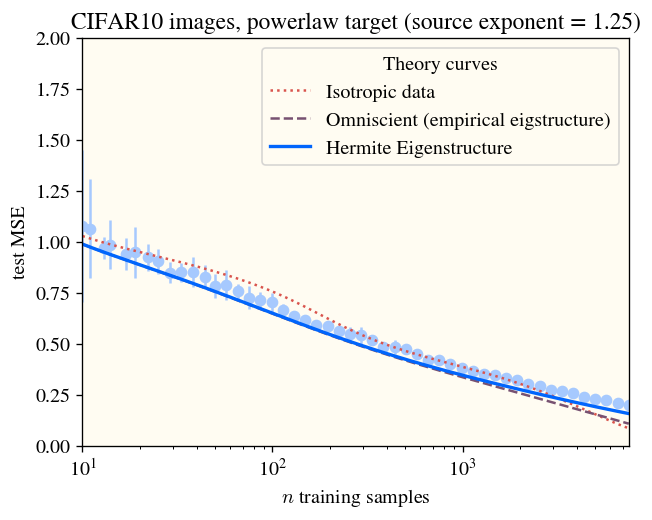

In [115]:
fig, ax = plt.subplots(figsize=(5.5, 4.5))
colors = ['xkcd:bright blue', 'xkcd:aubergine', 'xkcd:pale red']
ax.errorbar(ntrains, lrn_curve_emp, yerr=lrn_curve_emp_std, color=lighten(colors[0], 0.65),
            ls='none', marker='o', zorder=-4)
ax.plot(ntrains_dense, mse_el_iso, color=colors[2], ls=":", label="Isotropic data")
ax.plot(ntrains_dense, mse_el_emp, color=lighten(colors[1], .3), ls="--", label="Omniscient (empirical eigstructure)")
ax.plot(ntrains_dense, mse_el_hehe, color=colors[0], lw=2, label="Hermite Eigenstructure")

ax.set_title(f"CIFAR10 images, powerlaw target (source exponent = {target})",
             fontsize=14)
ax.set_xlabel(f"$n$ training samples")
ax.set_ylabel("test MSE")
ax.set_xlim(ntrains[0], ntrains[-1])
ax.set_ylim(0, 2)

ax.set_xscale("log")
ax.legend(title="Theory curves")
plt.tight_layout()
plt.show()

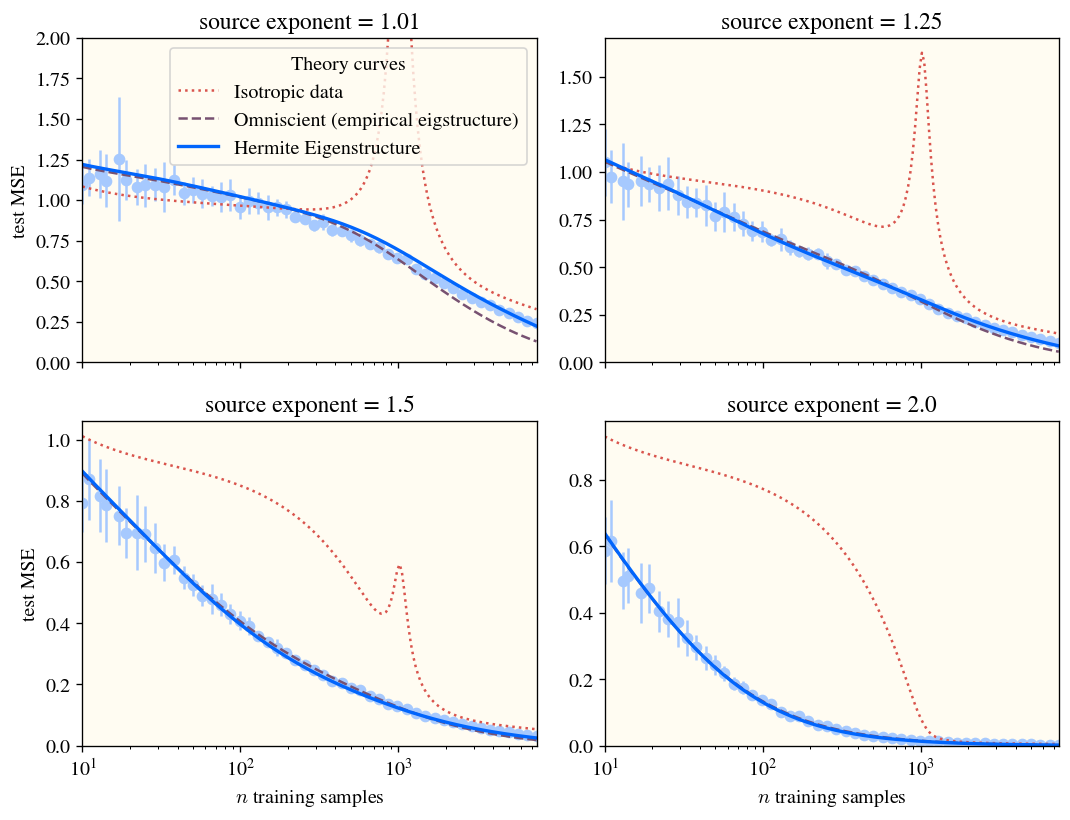

In [115]:
fig, axes = plt.subplots(2, 2, figsize=(9, 7), sharex=True)
colors = ['xkcd:bright blue', 'xkcd:aubergine', 'xkcd:pale red']

for i, ax in enumerate(axes.flat):
    target = list(targets.keys())[i]
    ystar = targets[target]
    emp_coeffs, hehe_coeffs = calc_coeffs(ystar, H, emp_eigvecs)
    
    mse_stats = np.array([[get_mse_stats(n, ridges[0], target)] for n in ntrains]).squeeze()
    mse_mean, mse_std = mse_stats[:, 0], mse_stats[:, 1]

    ntrains_dense = np.logspace(np.log10(ntrains[0]), np.log10(ntrains[-1]), 200)
    el_emp = lambda n: eigenlearning(n, emp_eigvals, emp_coeffs, ridge=ridges[0])
    el_hehe = lambda n: eigenlearning(n, hehe_eigvals, hehe_coeffs, ridge=ridges[0])
    el_iso = lambda n: eigenlearning(n, iso_eigvals, hehe_coeffs, ridge=ridges[0])
    mse_el_emp = np.array([el_emp(n)["test_mse"] for n in ntrains_dense])
    mse_el_hehe = np.array([el_hehe(n)["test_mse"] for n in ntrains_dense])
    mse_el_iso = np.array([el_iso(n)["test_mse"] for n in ntrains_dense])

    ax.errorbar(ntrains, mse_mean, yerr=mse_std, color=lighten(colors[0], 0.65),
                ls='none', marker='o', zorder=-4)
    ax.plot(ntrains_dense, mse_el_iso, color=colors[2], ls=":", label="Isotropic data")
    ax.plot(ntrains_dense, mse_el_emp, color=lighten(colors[1], .3), ls="--", label="Omniscient (empirical eigstructure)")
    ax.plot(ntrains_dense, mse_el_hehe, color=colors[0], lw=2, label="Hermite Eigenstructure")

    ax.set_title(f"source exponent = {target}",
                fontsize=14)
    if i > 1:
        ax.set_xlabel(f"$n$ training samples")
    if i % 2 == 0:
        ax.set_ylabel("test MSE")
    ax.set_xlim(ntrains[0], ntrains[-1])
    ytop = min(ax.get_ylim()[1], 2)
    ax.set_ylim(0, ytop)

    ax.set_xscale("log")

axes.flat[0].legend(title="Theory curves")
plt.tight_layout()
plt.show()